##  Notebook 00a: sub-SEVIR Classification ML Models 

### Goal: Train and evaluate classification ML models on the sub-SEVIR dataset 

In this notebook, we train and evaluate classification machine learning (ML) models on the sub-SEVIR dataset. sub-SEVIR is a lower-resolution version of the Storm Event Imagery Dataset. The new spatial resolution is 8 km with a 60 min timestep resolution for each event. Our goal is to train a classification model to predict whether a storm-centered image contains a lightning flash (yes/no). 

For simplicity, we limited our model selection to logistic regression, random forests, and gradient-boosted trees. For each model, the default hyperparameters were used. 

#### Import the neccesary packages

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline 

In [2]:
import sys,os
top_path = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(top_path,'scripts/'))

# Plots ROC, performance, and reliability diagram given a model, X, and y
from verification import plot_verification
from util import load_ml_data 

### Load the data 

We have provided a IO function for loading the ML data. Uncomment the following cell and execute it to learn more about the input arguments. 

In [3]:
# Uncomment and execute this cell to learn about the input args.
#help(load_ml_data)

In [4]:
import numpy as np
X_train, y_train, X_val, y_val, X_test, y_test = load_ml_data()

### Create the model pipelines and fit the models

When training ML models, we often have to pre-processing the data. For this example, we want to scaling the data so that each feature has a mean of zero and variance of 1. Scikit-learn has a great feature known as [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) where the pre-processing is incorporated into the model. Thus, when call `.predict` or `.predict_proba`, the pre-processing is applied internally. 


In [5]:
# Make a pipeline. 
steps = [('StandardScaler', StandardScaler() )]
clfs = [( 'LR', LogisticRegression(max_iter=300)), 
        ( 'GBT', HistGradientBoostingClassifier(loss='binary_crossentropy')), 
        ( 'RF', RandomForestClassifier(n_estimators=200, n_jobs=4))
       ]

fit_clfs = [(e[0], Pipeline(steps+[e]).fit(X_train, y_train)) for e in clfs]

### Evaluate the model performance 

We provide verification plotting scripts for classification and regression. In this example, we can pass in our fit classifiers and the testing data (`X_test` and `y_test`) and get the reliability, performance, and ROC diagrams. These are the bootstrap mean curves for each diagram. 



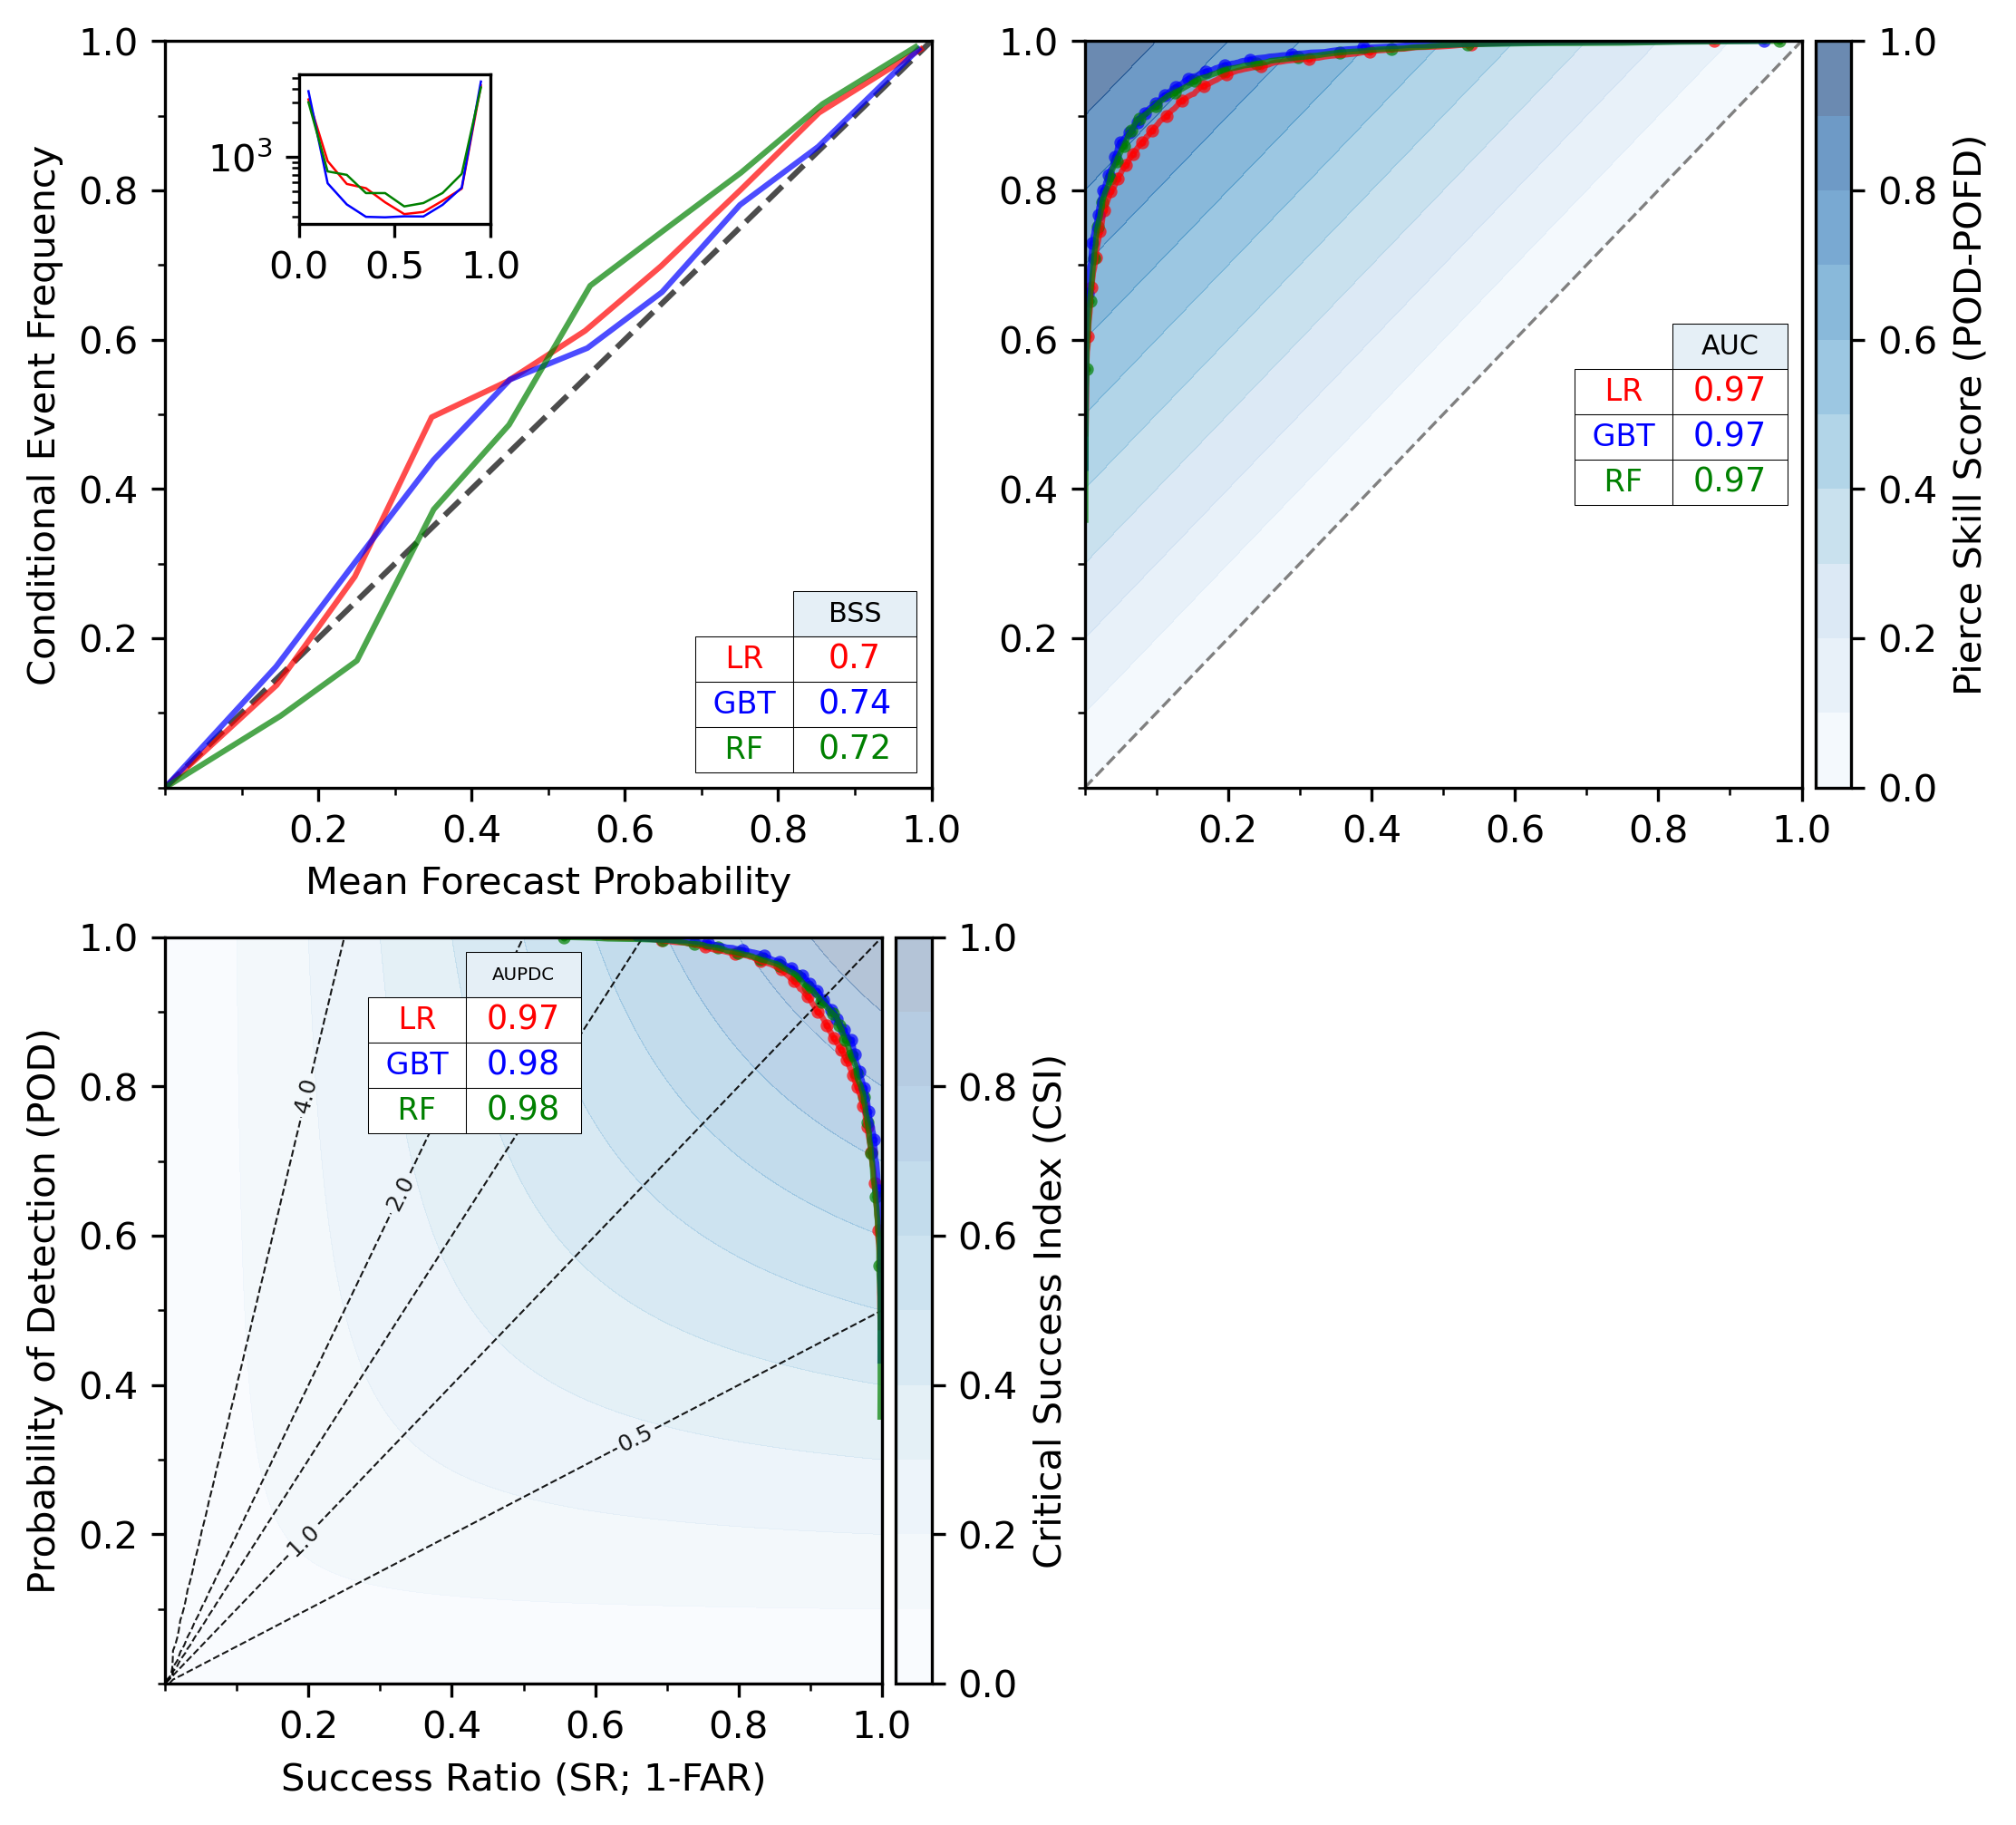

In [6]:
plot_verification(fit_clfs, X_test, y_test.values)

## Limitations of the Model Verification 

There are a couple of limitations to be mindful of when interpreting the model performance. 

1. First, the SEVIR (and sub-SEVIR) dataset has been balanced such that the number of examples associated and not associated with lightning are the same. In reality, we know that clouds will often not be associated with lightning flashes due to infrequency of lightning. When the dataset has been skewed in this way, it skews the false alarm rate (FAR). Thus, we would anticipate the FAR to be much higher when this model is applied in the "real world" or "out in the wild". 

2. These results show the average model performance over many cases. Depending on the circumstances, we are likely to see the model perform better or worse than these results. 

### Save the models using joblib

In [7]:
import joblib 
from os.path import join

# Save the models 
path = '../models'
for name, clf in fit_clfs:
    joblib.dump(clf, join(path, f'{name}_classification.joblib'), compress=3)